# Analyzing the Effect of Nutrition (Specifically Protein Content) on COVID-19 Cases Around the World

By: Justin Lu

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/covid19-healthy-diet-dataset/Protein_Supply_Quantity_Data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
from scipy.stats import mode

In [4]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Source: Maria Ren on Kaggle
* Nutritional data from the UN's Food and Agriculture Organization
* Population data from the Population Reference Bureau
* COVID-19 data from Johns Hopkins Center for Systems Science and Engineering

In [5]:
protein = pd.read_csv('/kaggle/input/covid19-healthy-diet-dataset/Protein_Supply_Quantity_Data.csv')
protein.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.081402,0.001895,0.033132,0.046375,38042000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.084045,0.001924,0.048425,0.033695,2858000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.030579,0.002067,0.021589,0.006923,43406000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.000850,0.000035,0.000258,0.000557,31427000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.071134,0.003093,0.022680,0.045361,97000.0,%


In [6]:
protein.shape

(170, 32)

In [7]:
protein.columns

Index(['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats',
       'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat',
       'Milk - Excluding Butter', 'Offals', 'Oilcrops', 'Pulses', 'Spices',
       'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners',
       'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables',
       'Miscellaneous', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'Population', 'Unit (all except Population)'],
      dtype='object')

## Cleaning
Based on a cursory overview of the columns in our dataset, we can tell that most of these variables *could* be significant predictors of COVID-19 spread. The last column, `Unit (all except Population)`, is potentially less useful, as it is just an indication that the data we are working with are all in percentages.

In [8]:
protein = protein.drop(['Unit (all except Population)'], axis = 1)
protein.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,0.0000,1.1370,0.0462,4.5,29.8,0.081402,0.001895,0.033132,0.046375,38042000.0
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,0.0084,3.2456,0.0544,22.3,6.2,0.084045,0.001924,0.048425,0.033695,2858000.0
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,0.0269,3.1267,0.1399,26.6,3.9,0.030579,0.002067,0.021589,0.006923,43406000.0
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.0092,0.8133,0.0924,6.8,25,0.000850,0.000035,0.000258,0.000557,31427000.0
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,0.0430,1.6024,0.2947,19.1,NaN,0.071134,0.003093,0.022680,0.045361,97000.0


Another area of cleaning that must be done is the presence of NaN (empty or missing) values in the dataset. The process of dealing with these missing values is known as **data imputation**. Now, we take a look at what values in the dataset are missing and how to deal with it before we start analyzing/creating models.

In [9]:
protein.isna().sum()

Country                     0
Alcoholic Beverages         0
Animal Products             0
Animal fats                 0
Aquatic Products, Other     0
Cereals - Excluding Beer    0
Eggs                        0
Fish, Seafood               0
Fruits - Excluding Wine     0
Meat                        0
Milk - Excluding Butter     0
Offals                      0
Oilcrops                    0
Pulses                      0
Spices                      0
Starchy Roots               0
Stimulants                  0
Sugar Crops                 0
Sugar & Sweeteners          0
Treenuts                    0
Vegetal Products            0
Vegetable Oils              0
Vegetables                  0
Miscellaneous               0
Obesity                     3
Undernourished              7
Confirmed                   9
Deaths                      9
Recovered                   9
Active                      9
Population                  0
dtype: int64

There are many ways to go about imputing a missing value, but for this purpose, I chose to fill them with the average value of that specific column.
We can see that some data pertaining to health in the countries, specifically the `Obesity` and `Undernourished` columns, are missing. For these two missing columns, I decided to impute with the average of the column. For the `Confirmed`, `Deaths`, `Recovered`, and `Active` columns, it was possible that data was unavailable/not provided. For example, it is difficult to obtain COVID data from North Korea, because their government probably would not provide it. It is also possible that, at the time that this data was obtained, some countries had not shown cases yet because there was no travel to or from that country. (We know now that every country on the planet has experienced cases of COVID-19.) Therefore, to keep things consistent, I opted to remove these countries from the analysis.

In [10]:
protein['Undernourished'] = protein['Undernourished'].replace({'<2.5': 2.5})
protein['Undernourished'] = np.array(protein['Undernourished']).astype(np.float)

In [11]:
protein['Obesity'] = protein['Obesity'].fillna(protein['Obesity'].mean())
protein['Undernourished'] = protein['Undernourished'].fillna(np.nanmean(protein['Undernourished']))

In [12]:
protein[protein['Confirmed'].isna() == True]

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
52,French Polynesia,0.3778,32.9981,0.2042,0.0153,10.7050,1.1741,7.0448,0.3931,18.8677,...,0.0153,1.2558,1.1129,18.707784,4.2,NaN,NaN,NaN,NaN,279000.0
80,Kiribati,0.0338,24.9594,0.0473,0.0000,15.3680,0.4058,16.1052,0.9131,7.6502,...,0.0000,1.3731,0.1420,45.600000,2.7,NaN,NaN,NaN,NaN,123000.0
81,"Korea, North",0.0287,10.0832,0.0000,0.0000,23.9070,1.3872,2.9561,0.6218,5.0990,...,0.0000,4.6398,0.0287,7.100000,47.8,NaN,NaN,NaN,NaN,25666000.0
105,Myanmar,0.0161,23.9286,0.0911,0.0000,16.0006,0.8517,8.7797,0.4018,10.2743,...,0.0000,1.8213,0.0804,5.700000,10.6,NaN,NaN,NaN,NaN,54045000.0
109,New Caledonia,0.3262,29.1790,0.1873,0.0181,13.6531,1.6915,3.9207,0.6585,15.3749,...,0.0362,1.7640,1.1841,18.707784,7.1,NaN,NaN,NaN,NaN,291000.0
131,Samoa,0.1866,30.9096,0.1341,0.1341,8.4665,0.4023,7.3761,1.6968,19.3878,...,0.0058,0.5364,0.3032,45.500000,2.7,NaN,NaN,NaN,NaN,199000.0
139,Solomon Islands,0.1398,14.7782,0.0839,0.0186,15.0205,0.3168,9.1129,0.5498,3.9415,...,0.0000,0.4752,0.2329,20.500000,8.9,NaN,NaN,NaN,NaN,699000.0
155,Turkmenistan,0.0000,21.5563,0.0485,0.0000,24.3242,1.1201,0.4685,0.4254,12.3586,...,0.0162,1.8255,0.0915,17.500000,5.4,NaN,NaN,NaN,NaN,5942000.0
164,Vanuatu,0.0078,19.8713,0.0863,0.0000,14.6387,0.6119,6.8016,1.1532,9.8533,...,0.0078,1.5847,0.1020,23.500000,7.2,NaN,NaN,NaN,NaN,313000.0


In [13]:
protein = protein.drop(np.array(protein[protein['Confirmed'].isna() == True].index), axis = 0).reset_index(drop = True)

In [14]:
# cleaned dataset 
protein.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,0.0000,1.1370,0.0462,4.5,29.800000,0.081402,0.001895,0.033132,0.046375,38042000.0
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,0.0084,3.2456,0.0544,22.3,6.200000,0.084045,0.001924,0.048425,0.033695,2858000.0
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,0.0269,3.1267,0.1399,26.6,3.900000,0.030579,0.002067,0.021589,0.006923,43406000.0
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.0092,0.8133,0.0924,6.8,25.000000,0.000850,0.000035,0.000258,0.000557,31427000.0
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,0.0430,1.6024,0.2947,19.1,11.229448,0.071134,0.003093,0.022680,0.045361,97000.0


## Exploratory Data Analysis

I want to extract some quick statistics and plots to better understand what the data distribution looks like.

In [15]:
top = protein[protein['Population'] > 100000000].sort_values(by = 'Confirmed', ascending = False)[:20]
top

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
153,United States of America,0.2946,32.4775,0.0264,0.0044,10.4594,2.0048,2.3873,0.5935,18.0875,...,0.0835,1.3981,0.0000,37.3,2.5,0.774411,0.038220,0.208160,0.504052,3.291530e+08
20,Brazil,0.2807,29.0557,0.1266,0.0000,12.1671,1.1831,1.3537,0.7759,18.7486,...,0.0220,0.8089,0.0000,22.3,2.5,0.642111,0.027527,0.356380,0.258204,2.093320e+08
121,Russian Federation,0.3436,27.3905,0.0834,0.0000,16.2085,2.3071,3.2496,0.4123,12.6006,...,0.0245,1.6150,0.0442,25.7,2.5,0.431785,0.006175,0.271542,0.154069,1.467310e+08
97,Mexico,0.2784,23.4422,0.0107,0.0161,19.3737,2.8587,2.3287,0.9047,11.1188,...,0.0214,1.2473,0.0054,28.4,3.6,0.171320,0.021053,0.130076,0.020192,1.265770e+08
112,Pakistan,0.0000,21.0264,0.0604,0.0000,20.8679,0.7472,0.4151,0.2868,4.4830,...,0.1132,0.9358,0.0226,7.8,20.3,0.095358,0.001924,0.044055,0.049379,2.165650e+08
11,Bangladesh,0.0000,9.9195,0.0083,0.0000,31.7243,0.7216,5.8306,0.3069,1.2773,...,0.0000,1.2026,0.0249,3.4,14.7,0.084187,0.001062,0.034049,0.049076,1.636670e+08
67,India,0.0077,11.2582,0.0306,0.0000,25.2794,0.7271,1.5537,0.6659,1.0179,...,0.0000,2.3343,0.0000,3.8,14.5,0.039394,0.001184,0.023114,0.015096,1.391885e+09
116,Philippines,0.1914,20.5089,0.3191,0.0000,23.2770,1.0211,6.6369,1.2763,9.6682,...,0.0000,1.9863,0.0558,6.0,13.3,0.032793,0.001151,0.008959,0.022684,1.081170e+08
68,Indonesia,0.0073,16.1640,0.0219,0.0000,27.3237,1.2821,10.1617,0.7430,2.9210,...,0.0000,1.2966,0.0073,6.9,8.3,0.020122,0.001026,0.008545,0.010551,2.684190e+08
75,Japan,0.2541,27.7588,0.0058,0.0635,12.4213,3.5687,9.5744,0.3292,9.8112,...,0.0289,1.9923,0.0635,4.4,2.5,0.014555,0.000770,0.012939,0.000846,1.261800e+08


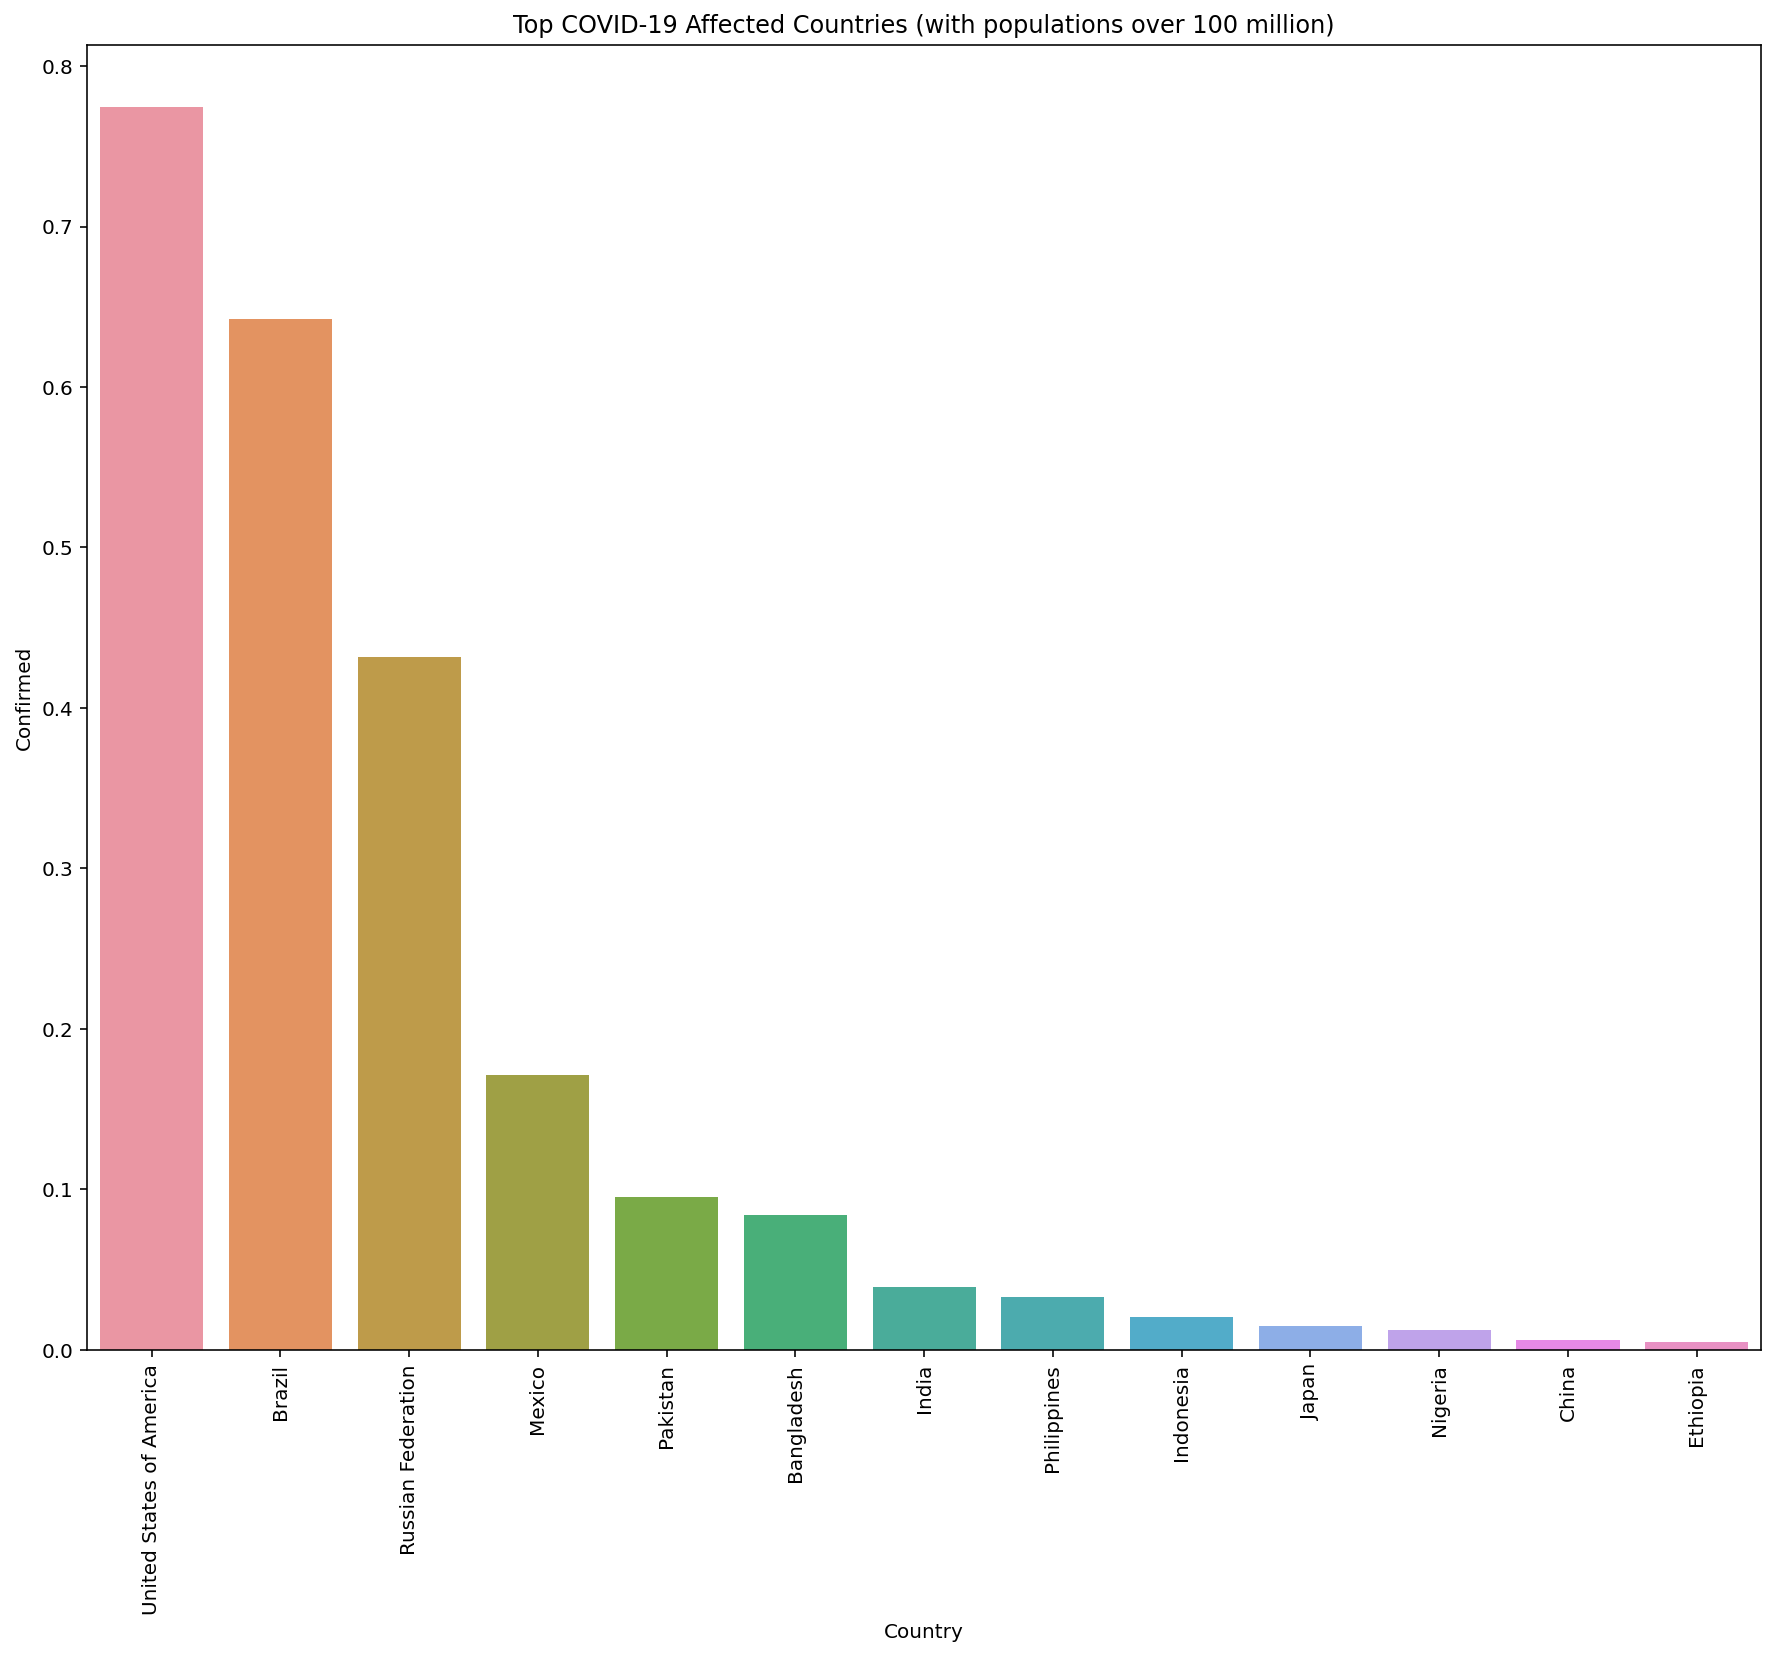

In [16]:
plt.figure(figsize=(15,12))
plt.title("Top COVID-19 Affected Countries (with populations over 100 million)")
ax = sns.barplot(x = top.Country, y = top.Confirmed)
suppress = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

I also wanted to view the distribution of confirmed case percentage across the countries in the dataset.

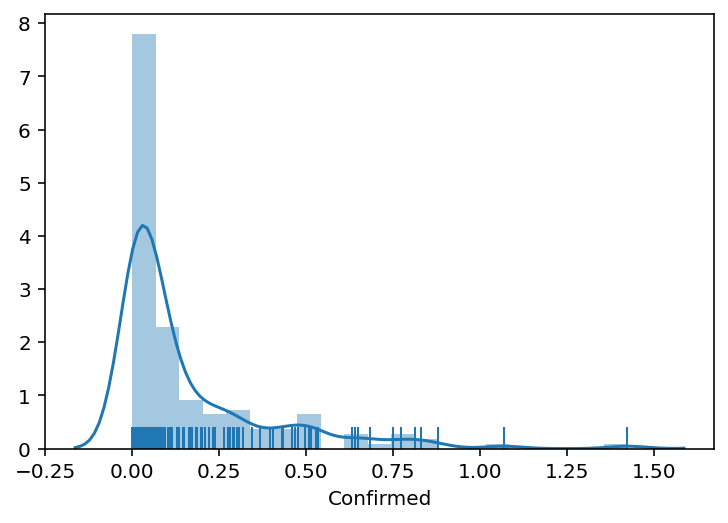

In [17]:
sns.distplot(protein['Confirmed'], rug = True)

To further cut down on the features I want to use in my models, I decided to extract features that I felt would be most useful in my analysis and model building. These features (available in the dataset) consisted of foods with high protein content, as well as the features pertaining to overall health of each country (i.e., obesity and undernourishment percentages).

For the baseline model, I chose these features: `Animal Products`, `Cereals - Excluding Beer`, `Eggs`, `Fish, Seafood`, `Meat`, `Treenuts`, `Vegetal Products`, `Vegetables`, `Obesity`, and `Undernourished` columns to predict the `Confirmed` variable.

In [18]:
test_dat = protein[['Animal Products', 'Cereals - Excluding Beer', 'Eggs', 
                  'Fish, Seafood', 'Meat', 'Treenuts', 'Vegetal Products', 
                  'Vegetables', 'Obesity', 'Undernourished', 'Confirmed']]
test_dat

,Animal Products,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Meat,Treenuts,Vegetal Products,Vegetables,Obesity,Undernourished,Confirmed
0,9.7523,35.9771,0.4067,0.0647,3.1337,0.1387,40.2477,1.1370,4.5,29.800000,0.081402
1,27.7469,14.2331,1.8069,0.6274,7.6582,0.2677,22.2552,3.2456,22.3,6.200000,0.084045
2,13.8360,26.5633,1.2916,0.6350,3.5088,0.2745,36.1694,3.1267,26.6,3.900000,0.030579
3,15.2311,20.3882,0.1756,5.4436,7.6248,0.0092,34.7782,0.8133,6.8,25.000000,0.000850
4,33.1901,10.5108,0.4850,8.2146,16.0670,0.0737,16.8161,1.6024,19.1,11.229448,0.071134
...,...,...,...,...,...,...,...,...,...,...,...
156,22.5411,21.6526,0.8707,2.6477,11.8347,0.0000,27.4545,1.0129,25.2,21.200000,0.018576
157,20.4466,18.5247,0.7665,5.7435,11.0426,0.3277,29.5617,3.7216,2.1,9.300000,0.000371
158,10.0122,35.1179,0.4320,0.9392,5.9453,0.0188,39.9831,0.5448,14.1,38.900000,0.003834
159,9.8925,28.5182,0.5839,3.0126,4.3158,0.0000,40.1117,0.8039,6.5,46.700000,0.008717


## Baseline Model - Using Regular Linear Regression

In [19]:
X = test_dat[['Animal Products', 'Cereals - Excluding Beer', 'Eggs', 
                  'Fish, Seafood', 'Meat', 'Treenuts', 'Vegetal Products', 
                  'Vegetables', 'Obesity', 'Undernourished']]
y = test_dat['Confirmed']

In [20]:
types = X.dtypes
numcols = types.loc[types != np.object].index

In [29]:
ct = ColumnTransformer([
    ('numcols', SimpleImputer(strategy = 'constant', fill_value = 0), numcols)
])

pl = Pipeline([('feats', ct), ('reg', LinearRegression())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl.fit(X_tr, y_tr)
pl.score(X_ts, y_ts)

0.1491853032149424

## After Feature Selection/Engineering - Random Forest Regression
- Standardization - converting predictor variables to standard units
- More weeding out of variables/engineering

In [22]:
final_X = test_dat[['Animal Products', 'Cereals - Excluding Beer', 
                    'Vegetal Products', 'Obesity', 'Undernourished']]
final_y = test_dat['Confirmed']
numcols = ['Obesity', 'Undernourished', 'Cereals - Excluding Beer', 'Vegetal Products', 'Animal Products']

In [46]:
perc_pipe = Pipeline([
    ('imp', SimpleImputer(strategy = 'mean')),
    ('percentage_transform', StandardScaler())
])

ct = ColumnTransformer([ 
    ('perc_cols', perc_pipe, numcols)
])

pl = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(final_X, final_y, test_size=0.25)
pl.fit(X_tr, y_tr)
pl.score(X_ts, y_ts)

0.30327464114832536

The accuracy of using regression from sklearn is very fickle, as we can see.

## Neural Network with Keras

To experiment with Keras, I need to convert the data, specifically the predict variable into a categorical variable. To do this, I will split them into two groups: countries that have greater than 0.07% confirmed case rate and those that do not.

In [24]:
test_dat.head()

,Animal Products,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Meat,Treenuts,Vegetal Products,Vegetables,Obesity,Undernourished,Confirmed
0,9.7523,35.9771,0.4067,0.0647,3.1337,0.1387,40.2477,1.1370,4.5,29.800000,0.081402
1,27.7469,14.2331,1.8069,0.6274,7.6582,0.2677,22.2552,3.2456,22.3,6.200000,0.084045
2,13.8360,26.5633,1.2916,0.6350,3.5088,0.2745,36.1694,3.1267,26.6,3.900000,0.030579
3,15.2311,20.3882,0.1756,5.4436,7.6248,0.0092,34.7782,0.8133,6.8,25.000000,0.000850
4,33.1901,10.5108,0.4850,8.2146,16.0670,0.0737,16.8161,1.6024,19.1,11.229448,0.071134


In [47]:
test_dat['Confirmed'] = (test_dat['Confirmed'] > 0.07).astype(int)

In [72]:
test_dat

,Animal Products,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Meat,Treenuts,Vegetal Products,Vegetables,Obesity,Undernourished,Confirmed
0,9.7523,35.9771,0.4067,0.0647,3.1337,0.1387,40.2477,1.1370,4.5,29.800000,1
1,27.7469,14.2331,1.8069,0.6274,7.6582,0.2677,22.2552,3.2456,22.3,6.200000,1
2,13.8360,26.5633,1.2916,0.6350,3.5088,0.2745,36.1694,3.1267,26.6,3.900000,0
3,15.2311,20.3882,0.1756,5.4436,7.6248,0.0092,34.7782,0.8133,6.8,25.000000,0
4,33.1901,10.5108,0.4850,8.2146,16.0670,0.0737,16.8161,1.6024,19.1,11.229448,1
...,...,...,...,...,...,...,...,...,...,...,...
156,22.5411,21.6526,0.8707,2.6477,11.8347,0.0000,27.4545,1.0129,25.2,21.200000,0
157,20.4466,18.5247,0.7665,5.7435,11.0426,0.3277,29.5617,3.7216,2.1,9.300000,0
158,10.0122,35.1179,0.4320,0.9392,5.9453,0.0188,39.9831,0.5448,14.1,38.900000,0
159,9.8925,28.5182,0.5839,3.0126,4.3158,0.0000,40.1117,0.8039,6.5,46.700000,0


In [73]:
final_X = test_dat[['Animal Products', 'Cereals - Excluding Beer', 
                    'Vegetal Products', 'Obesity', 'Undernourished']]
final_y = test_dat['Confirmed']

In [74]:
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [75]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
model.fit(final_X, final_y, epochs=150, batch_size=10)

Epoch 1/150
17/17 [==============================] - 0s 1ms/step - loss: 2.5692 - accuracy: 0.5031
Epoch 2/150
17/17 [==============================] - 0s 1ms/step - loss: 1.7586 - accuracy: 0.4534
Epoch 3/150
17/17 [==============================] - 0s 1ms/step - loss: 1.4806 - accuracy: 0.4224
Epoch 4/150
17/17 [==============================] - 0s 1ms/step - loss: 1.2620 - accuracy: 0.4596
Epoch 5/150
17/17 [==============================] - 0s 1ms/step - loss: 1.0971 - accuracy: 0.5342
Epoch 6/150
17/17 [==============================] - 0s 1ms/step - loss: 1.0013 - accuracy: 0.5590
Epoch 7/150
17/17 [==============================] - 0s 1ms/step - loss: 0.9334 - accuracy: 0.5963
Epoch 8/150
17/17 [==============================] - 0s 1ms/step - loss: 0.8949 - accuracy: 0.6025
Epoch 9/150
17/17 [==============================] - 0s 1ms/step - loss: 0.8528 - accuracy: 0.6273
Epoch 10/150
17/17 [==============================] - 0s 1ms/step - loss: 0.8318 - accuracy: 0.6273
Epoch 11/

17/17 [==============================] - 0s 1ms/step - loss: 0.5767 - accuracy: 0.6770
Epoch 84/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5778 - accuracy: 0.6770
Epoch 85/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5756 - accuracy: 0.6832
Epoch 86/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5752 - accuracy: 0.6894
Epoch 87/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5786 - accuracy: 0.6832
Epoch 88/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5744 - accuracy: 0.6832
Epoch 89/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5753 - accuracy: 0.6832
Epoch 90/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5731 - accuracy: 0.6646
Epoch 91/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5711 - accuracy: 0.6770
Epoch 92/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5677 - accuracy: 0.6708
Epoch 93/150


## Conclusion
As we can see, using Keras and neural network classification yields much better results and accuracy of prediction. But, this must be taken with a grain of salt, as we simplified the problem by making it into a classification problem rather than a regression problem when we split the prediction variable into two groups. Therefore, although nutrition may be a factor in predicting COVID case rates, it should not be the sole predictor. 